Final Time: 31.71 years
eccentricities =  [0.94981605 1.18028572 1.09279758 1.03946339 0.86240746 0.86239781
 0.82323344 1.14647046]


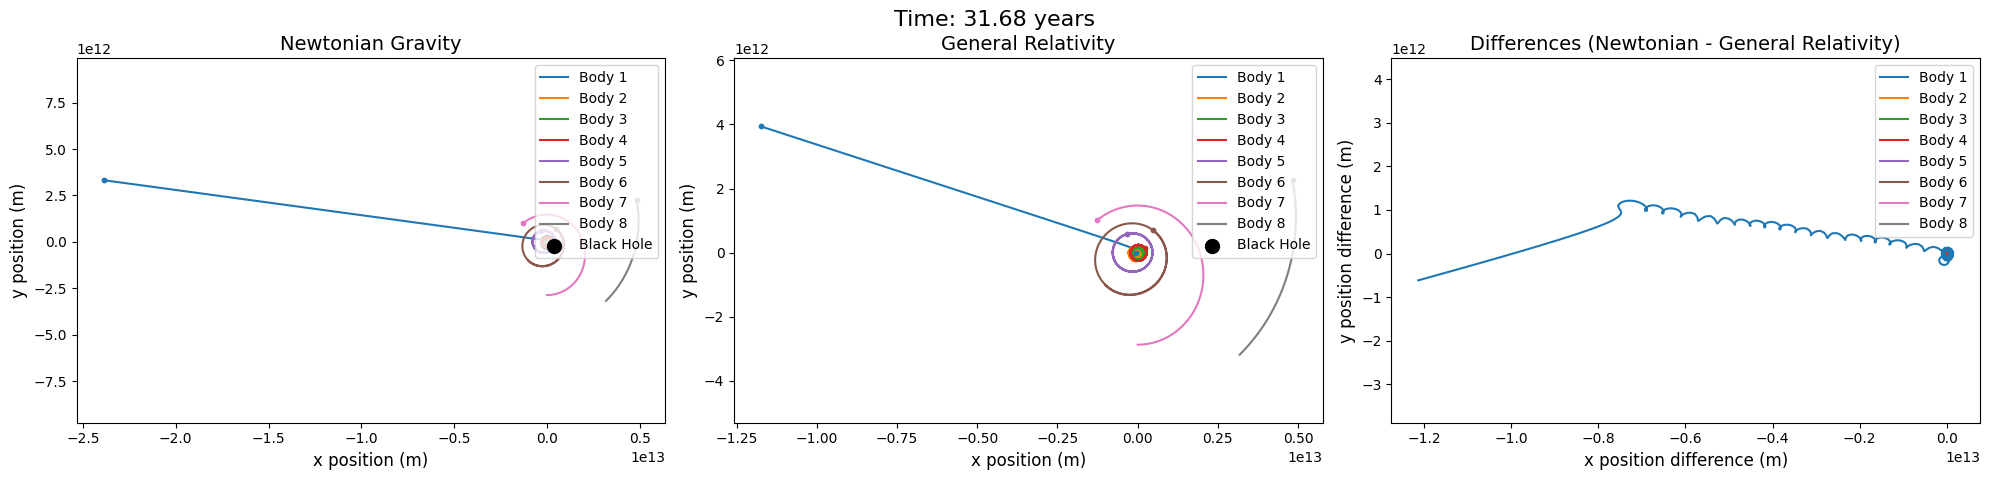

In [23]:
"""
Simulate multi-body gravitational dynamics comparing Newtonian and General Relativity effects.

This script simulates the motion of multiple bodies orbiting around a central massive black hole.
It compares the Newtonian dynamics with General Relativity corrections highlighting differences.

Parameters:
-----------
n_bodies : int
    Number of orbiting bodies.

total_time : float
    Total simulation time in seconds.

dt : float
    Time step for the simulation in seconds.

masses : numpy.ndarray
    Masses of the orbiting bodies in kg.

black_hole_mass : float
    Mass of the central black hole in kg.

black_hole_position : numpy.ndarray
    Position of the black hole in 2D space.

orbital_radii : numpy.ndarray
    Initial radial distances of the bodies from the black hole.

theta : numpy.ndarray
    Initial angular positions of the bodies.

velocities : numpy.ndarray
    Initial velocities of the bodies.

eccentricity_factor : numpy.ndarray
    Factors introducing eccentricity in the orbits.

Returns:
--------
matplotlib.animation.FuncAnimation
    Animation object representing the simulation.
"""

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation


# constants
G = 6.67430e-11  # gravitational constant, m^3 kg^-1 s^-2
c = 3.00e8       # speed of light, m/s

# number of bodies (excluding the "black hole")
n_bodies = 8  # number of planets in the solar system (for now!)

# time step (s)
dt = 1e6

# total simulation time (s), maybe increase this?
total_time = 1e9
print(f'Final Time: {total_time / (365 * 24 * 3600):.2f} years')

# number of steps
n_steps = int(total_time / dt)

# masses of the bodies (kg) - masses of the planets in the solar system
masses = np.array([
    3.30e23,  # Mercury
    4.87e24,  # Venus
    5.97e24,  # Earth
    6.42e23,  # Mars
    1.90e27,  # Jupiter
    5.69e26,  # Saturn
    8.68e25,  # Uranus
    1.02e26   # Neptune
])

# black hole mass and position, guess it 
black_hole_mass = 1.989e30  # solar mass in kg
black_hole_position = np.array([0.0, 0.0])

# initial positions (m) arranged in a circle around the BH for simplicity...
# using approximate average orbital radii of the planets in the solar system
orbital_radii = np.array([
    5.79e10,  # mercury
    1.08e11,  # venus
    1.50e11,  # earth
    2.28e11,  # mars
    7.78e11,  # jupiter
    1.43e12,  # saturn
    2.87e12,  # uranus
    4.50e12  # neptune
])
theta = np.linspace(0, 2*np.pi, n_bodies, endpoint=False)
positions = np.column_stack((orbital_radii * np.cos(theta), orbital_radii * np.sin(theta)))

# initial velocities (m/s) for elliptical orbits with some eccentricity
velocities = np.zeros((n_bodies, 2))

np.random.seed(42)
eccentricity_factor = np.random.uniform(0.8, 1.2, n_bodies)  # eccentricity
print('eccentricities = ', eccentricity_factor)

for i in range(n_bodies):
    r = np.linalg.norm(positions[i])
    v_circular = np.sqrt(G * black_hole_mass / r)
    v_elliptical = v_circular * eccentricity_factor[i]
    velocities[i] = v_elliptical * np.array([-np.sin(theta[i]), np.cos(theta[i])])

# initialize arrays to store positions and distances for plotting
positions_history_newtonian = np.zeros((n_steps, n_bodies, 2))
positions_history_relativity = np.zeros((n_steps, n_bodies, 2))

# func to compute relativistic correction
def relativistic_correction(r_vector, r_magnitude, velocity, mass):
    v_squared = np.dot(velocity, velocity)
    correction_factor = 1 + (3 * v_squared) / (c**2) - (G * black_hole_mass) / (r_magnitude * c**2)
    return correction_factor

# simulation
# newtonian
positions_newtonian = positions.copy()
velocities_newtonian = velocities.copy()

for step in range(n_steps):
    # store positions for plotting
    positions_history_newtonian[step] = positions_newtonian

    # calculate forces
    forces = np.zeros((n_bodies, 2))
    for i in range(n_bodies):
        # force due to the black hole
        r_vector = black_hole_position - positions_newtonian[i]
        r_magnitude = np.linalg.norm(r_vector)
        force_magnitude = G * black_hole_mass * masses[i] / r_magnitude**2
        forces[i] = force_magnitude * r_vector / r_magnitude

        # force due to other bodies
        for j in range(n_bodies):
            if i != j:
                r_vector = positions_newtonian[j] - positions_newtonian[i]
                r_magnitude = np.linalg.norm(r_vector)
                force_magnitude = G * masses[i] * masses[j] / r_magnitude**2
                forces[i] += force_magnitude * r_vector / r_magnitude

    # update velocities and positions
    velocities_newtonian += forces / masses[:, None] * dt
    positions_newtonian += velocities_newtonian * dt

# relativity
positions_relativity = positions.copy()
velocities_relativity = velocities.copy()

for step in range(n_steps):
    # store positions for plotting
    positions_history_relativity[step] = positions_relativity

    # calculate forces
    forces = np.zeros((n_bodies, 2))
    for i in range(n_bodies):
        # force due to the black hole
        r_vector = black_hole_position - positions_relativity[i]
        r_magnitude = np.linalg.norm(r_vector)
        force_magnitude = G * black_hole_mass * masses[i] / r_magnitude**2
        correction_factor = relativistic_correction(r_vector, r_magnitude, velocities_relativity[i], masses[i])
        forces[i] = force_magnitude * r_vector / r_magnitude * correction_factor

        # force due to other bodies
        for j in range(n_bodies):
            if i != j:
                r_vector = positions_relativity[j] - positions_relativity[i]
                r_magnitude = np.linalg.norm(r_vector)
                force_magnitude = G * masses[i] * masses[j] / r_magnitude**2
                correction_factor = relativistic_correction(r_vector, r_magnitude, velocities_relativity[i], masses[i])
                forces[i] += force_magnitude * r_vector / r_magnitude * correction_factor

    # update velocities and positions
    velocities_relativity += forces / masses[:, None] * dt
    positions_relativity += velocities_relativity * dt

# aaaaanimation function
def animate(frame):

    axs[0].clear()
    axs[1].clear()
    axs[2].clear()

    # plot Newtonian orbits
    for i in range(n_bodies):
        axs[0].plot(positions_history_newtonian[:frame, i, 0], positions_history_newtonian[:frame, i, 1], label=f'Body {i+1}')
        axs[0].scatter(positions_history_newtonian[frame-1, i, 0], positions_history_newtonian[frame-1, i, 1], s=10)  # Plot each body as a point at the current position
    axs[0].scatter(black_hole_position[0], black_hole_position[1], color='black', s=100, label='Black Hole')  # Black hole
    axs[0].set_xlabel('x position (m)', fontsize=12)
    axs[0].set_ylabel('y position (m)', fontsize=12)
    axs[0].set_title('Newtonian Gravity', fontsize=14)
    axs[0].axis('equal')
    axs[0].legend(loc=1)

    # plot Relativity orbits
    for i in range(n_bodies):
        axs[1].plot(positions_history_relativity[:frame, i, 0], positions_history_relativity[:frame, i, 1], label=f'Body {i+1}')
        axs[1].scatter(positions_history_relativity[frame-1, i, 0], positions_history_relativity[frame-1, i, 1], s=10)  # Plot each body as a point at the current position
    axs[1].scatter(black_hole_position[0], black_hole_position[1], color='black', s=100, label='Black Hole')  # Black hole
    axs[1].set_xlabel('x position (m)', fontsize=12)
    axs[1].set_ylabel('y position (m)', fontsize=12)
    axs[1].set_title('General Relativity', fontsize=14)
    axs[1].axis('equal')
    axs[1].legend(loc=1)

    # plot Differences
    for i in range(n_bodies):
        axs[2].plot(positions_history_newtonian[:frame, i, 0] - positions_history_relativity[:frame, i, 0],
                    positions_history_newtonian[:frame, i, 1] - positions_history_relativity[:frame, i, 1], label=f'Body {i+1}')
    axs[2].set_xlabel('x position difference (m)', fontsize=12)
    axs[2].set_ylabel('y position difference (m)', fontsize=12)
    axs[2].set_title('Differences (Newtonian - General Relativity)', fontsize=14)
    axs[2].axis('equal')
    axs[2].legend(loc=1)
    plt.tight_layout()
    
    # add time in years at the top
    current_time_years = frame * dt / (365 * 24 * 3600)  # in years
    fig.suptitle(f'Time: {current_time_years:.2f} years', fontsize=16, y=0.95)
    print(f'Simulation Time: {current_time_years:.2f} years', end='\r')


fig, axs = plt.subplots(1, 3, figsize=(20, 5))
#ani = animation.FuncAnimation(fig, animate, frames=n_steps, interval=100)
ani = animation.FuncAnimation(fig, animate, frames=n_steps, interval=10)
#ani = animation.FuncAnimation(fig, animate, frames=n_steps, interval=1)
ani.save('gravity_simulation.mp4', writer='ffmpeg')

## Save animation as gif
#ani.save('gravity_simulation.gif', writer='imagemagick')

plt.show()